In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import h5py

import pppc
from pppc.configs import InferenceConfigDict
from pppc.ptychonn.model import PtychoNNModel, PtychoNNTransposedConvModel, PtychoNNPhaseOnlyModel
from pppc.reconstructor import DatasetInferencer, TileStitcher
from pppc.position_list import ProbePositionList
from pppc.io import NPZFileHandle, HDF5FileHandle

os.chdir('/data/programs/probe_position_correction_w_ptychonn/workspace/2idd_siemens_star')

[2024-02-08 09:33:00,756] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-02-08 09:33:00,758] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
def clean_data(arr):
    mask = arr < 0
    vals = arr[mask]
    vals = 32768 + (vals - -32768)
    arr[mask] = vals
    return arr

def plot_distribution(x):
    x = x.reshape(-1)
    #x = x[x > 0]
    plt.hist(x, bins=32)
    plt.semilogy()
    plt.show()

In [5]:
save_figs = False

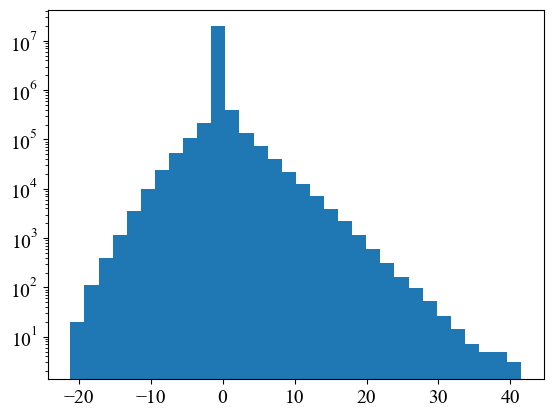

(1260, 128, 128) float32


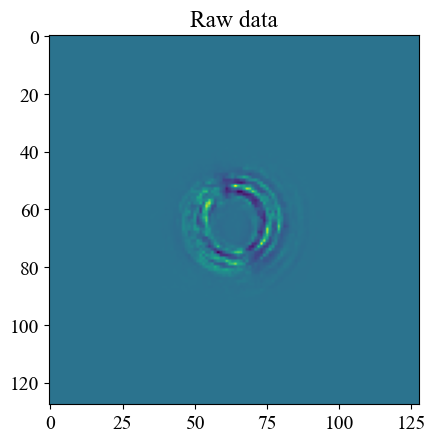

In [6]:
psize_nm = 16
config_dict = InferenceConfigDict(
    model_path='../../trained_models/model_2IDDSiemensStarDataset_labelPsize_16_std_meanSub_data_std_labels_every2Rows_bn_phaseOnlyModel_lr_1e-3_scheduledLR/best_model.pth',
    model=(PtychoNNPhaseOnlyModel, {'use_batchnorm': True}),
    batch_size=32,
    dp_data_file_handle=HDF5FileHandle('data/test/data_test_labelPsize_16_every2Rows_reduced_4_22.h5'),
)

plot_distribution(config_dict.dp_data_file_handle.array)
print(config_dict.dp_data_file_handle.array.shape, config_dict.dp_data_file_handle.array.dtype)
plt.figure()
plt.imshow(config_dict.dp_data_file_handle.array[0, :, :])
plt.title('Raw data')
plt.show()
# if 244 <= scan_idx <= 246: 
#     config_dict['dp_data_file_handle'].array = config_dict['dp_data_file_handle'].array.astype(float)
#     config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(-64, -64))
# else:
config_dict.cpu_only = False
config_dict.prediction_output_path = 'outputs/pred_{}_{}'.format(
    os.path.splitext(os.path.basename(config_dict.dp_data_file_handle.f.filename))[0],
    os.path.basename(os.path.dirname(config_dict.model_path)))

/tmp/ipykernel_4157083/1015607776.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(config_dict['dp_data_file_handle'].array[0, :, :] + 1e-6))


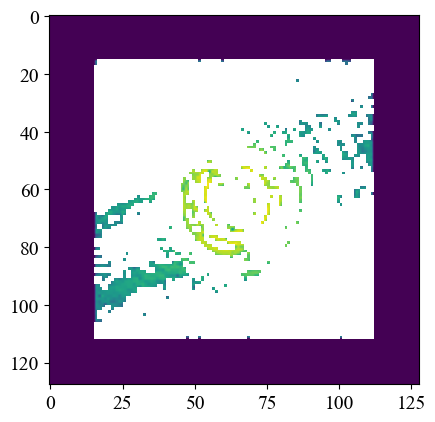

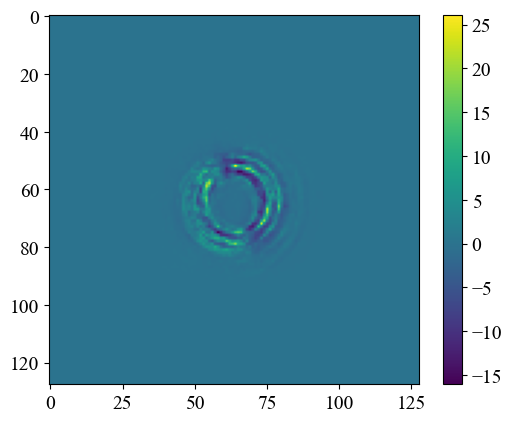

In [7]:
plt.figure()
plt.imshow(np.log10(config_dict.dp_data_file_handle.array[0, :, :] + 1e-6))
plt.figure()
plt.imshow(config_dict.dp_data_file_handle.array[0, :, :])
plt.colorbar()
plt.show()
#plot_distribution(config_dict['dp_data_file_handle'].array[:, :, :])

In [8]:
inferencer = DatasetInferencer(config_dict)
inferencer.build()
inferencer.run()
inferencer.convert_output_files_into_single_tiff('pred_phase', delete_individual_files_after_complete=True)
#inferencer.convert_output_files_into_single_tiff('pred_amp', delete_individual_files_after_complete=True)

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1228/1260 [00:01<00:00, 616.43it/s]


## Stitching

In [15]:
position_list = np.genfromtxt('data/test/pos_true_m_full.csv', delimiter=',') / (psize_nm * 1e-9)
config_dict.prediction_output_path = 'outputs/pred_data_test_labelPsize_16_every2Rows_model_2IDDSiemensStarDataset_labelPsize_16_std_meanSub_data_std_labels_every2Rows_bn_phaseOnlyModel_lr_1e-3_scheduledLR'
config_dict.probe_position_list = ProbePositionList(position_list=position_list, convert_to_pixel=False, first_is_x=False)
config_dict.central_crop = (108, 108)
config_dict.stitching_downsampling = 1

In [16]:
stitcher = TileStitcher(config_dict)
stitcher.flip_final_image = False
stitcher.build()
stitcher.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2450/2450 [00:10<00:00, 225.96it/s]


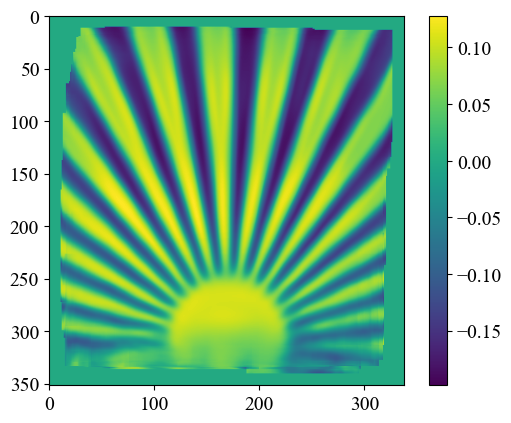

In [17]:
image_stitched_ptychonn = stitcher.image_stitched
fig, ax = plt.subplots(1, 1)
im = ax.imshow(image_stitched_ptychonn)
plt.colorbar(im)
save_figs = True
if save_figs:
    plt.savefig('outputs/test0_unscaled_reduced_4_22/stitched.pdf'.format(os.path.basename(os.path.dirname(config_dict['model_path']))))
else:
    plt.show()

In [23]:
import tifffile
tifffile.imwrite('../stitched_ptychonn_preds/2idd_siemens_star/stitched_pred.tiff', image_stitched_ptychonn)
import pandas as pd
pd.DataFrame(position_list * psize_nm * 1e-9).to_csv('../stitched_ptychonn_preds/2idd_siemens_star/pos_m.csv', index=False, header=False)